# Extracción de datos

## Imports para extracción

In [1]:
import pandas as pd 
import numpy as np
import oandapy as opy
import psycopg2
import logging
import os
from datetime import datetime as dt
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Extraemos datos de precios (Oanda) para el instrumento que elijamos y de twitter (Base de datos de Prophets)

### Oanda

In [107]:
def get_forex(instrument, instruments, granularity, start, end, candleformat, freq, trading=False):
    """
    Obtiene datos de FX de Oanda para los instrumentos que elijamos
    
    Args:
        instrument (str): Instrumento a predecir
        instruments (list): Divisas
        granularity (str): Time Window
        start (str): Primer día
        end (str): último día
        candleformat (str): 'bidask' o 'midpoint'
        freq (str): Timeframe
        trading (bool): Si estamos en producción
    Returns:
        df (DataFrame)
    
    """
    oanda = opy.API(environment='live')
    divs = {}

    for j in instruments:
        print(j)
        # Extraemos datos cada 2 días (por simplicidad)
        d1 = start
        d2 = end
        dates = pd.date_range(start=d1, end=d2, freq=freq)
        df = pd.DataFrame()
        print('Descargando:')
        pbar = tqdm(total=len(dates) - 1)

        for i in range(0, len(dates) - 1):
            # Oanda toma las fechas en este formato
            d1 = str(dates[i]).replace(' ', 'T')
            d2 = str(dates[i+1]).replace(' ', 'T')
            try:
                # Concatenamos cada día en el dataframe
                if trading == False:
                    data = oanda.get_history(instrument=j, 
                                             candleFormat=candleformat,
                                             start=d1, 
                                             end=d2, 
                                             granularity=granularity)
                else:
                    data = oanda.get_history(instrument=j, 
                                             candleFormat=candleformat,
                                             since=d1, 
                                             granularity=granularity)
                df = df.append(pd.DataFrame(data['candles']))
                pbar.update(1)
            except:
                pass
        pbar.close()
        date = pd.DatetimeIndex(df['time'], tz='UTC')
        df['date'] = date
        cols = [j + '_' + k for k in df.columns]
        df.columns = cols
        divs[j] = df
        
    dat = divs[instruments[0]]
    for i in instruments[1:]:
        join_id = [k for k in divs[i].columns if 'date' in k][0]
        dat = pd.merge(dat, divs[i], left_on=instrument + '_date', right_on=join_id, how='left')
        
    return dat

In [3]:
candleformat = 'midpoint' # ['midpoint', 'bidask']
instrument = 'USD_JPY'
instruments = ['USD_JPY', 
               'USB02Y_USD',
               'USB05Y_USD',
               'USB10Y_USD', 
               'USB30Y_USD',
               'UK100_GBP',
               'UK10YB_GBP',
               'JP225_USD',
               'HK33_HKD',
               'EU50_EUR',
               'DE30_EUR',
               'DE10YB_EUR',
               'WTICO_USD',
               'US30_USD',
               'SPX500_USD']
               
granularity = 'H1'
start = '2010-01-01'
end = str(dt.now())[:10]
freq = '15D'

In [4]:
#df1 = get_forex(instrument, instruments, granularity, start, end, candleformat, freq)

In [5]:
#df1.to_csv('Oanda_Merge_1H.csv')

# Read CSV

In [6]:
df1 = pd.read_csv('Oanda_Merge_1H.csv', index_col=0)

In [81]:
##### Checar logaritmos de volumenes

def adjust_lags(dat, min_window=None, instrument='USD_JPY', pricediff=True, candleformat='midpoint', log=True, trading=False):
    """
    Ajusta intervalos de tiempo en rangos de una hora
    
    Args:
        dat (DataFrame): Datos
        instrument (str): Divisa
        min_window (int): De cuántos minutos es cada intervalo
        pricediff (bool): Si queremos diferencias en precios
        candleformat (str): ['bidask', 'midpoint']
        log (bool): Si queremos transformación logarítmica
        trading (bool): Si estamos en producción
    Returns:
        df (DataFrame): Datos transformados y ajustados
    """
    
    df = dat.copy()
    date = '{}_date'.format(instrument)
    drops = [k for k in df.columns if date not in k and ('date' in k or 'complete' in k or 'time' in k)]
    df = df.drop(drops, axis=1)
    if trading == False:
        df = df[100:] # Falla en API
    df = df.reset_index(drop=True)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    drops = []
    if min_window:
        step = int(60/min_window)
    if candleformat == 'bidask':
        if pricediff:
            if log:
                for i in df.columns:
                    try:
                        df['Diff ' + i] = np.log(df[i]).diff(1)
                        drops.append(i)
                    except Exception as e:
                        print(e)
            else:

                for i in df.columns:
                    try:
                        df['Diff ' + i] = df[i] - df[i].shift(1)
                        drops.append(i)
                    except Exception as e:
                        print(e)
                        
            if min_window:
                
                open_bid = ['Diff openBid' + str(min_window*(i+1)) for i in range(step)]
                open_ask = ['Diff openAsk' + str(min_window*(i+1)) for i in range(step)]
                close_bid = ['Diff closeBid' + str(min_window*(i+1)) for i in range(step)]
                close_ask = ['Diff closeAsk' + str(min_window*(i+1)) for i in range(step)]
                low_bid = ['Diff lowBid' + str(min_window*(i+1)) for i in range(step)]
                low_ask = ['Diff lowAsk' + str(min_window*(i+1)) for i in range(step)]
                high_bid = ['Diff highBid' + str(min_window*(i+1)) for i in range(step)]
                high_ask = ['Diff highAsk' + str(min_window*(i+1)) for i in range(step)]
                volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

                shifts = list(range(1,step+1))

                for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                                             open_bid, 
                                                             open_ask, 
                                                             close_bid, 
                                                             close_ask, 
                                                             low_bid, 
                                                             low_ask, 
                                                             high_bid, 
                                                             high_ask, 
                                                             shifts):
                    df[v] = df['volume'].shift(s)
                    df[ob] = df['Diff openBid'].shift(s)
                    df[oa] = df['Diff openAsk'].shift(s)
                    df[cb] = df['Diff closeBid'].shift(s)
                    df[ca] = df['Diff closeAsk'].shift(s)
                    df[lb] = df['Diff lowBid'].shift(s)
                    df[la] = df['Diff lowAsk'].shift(s)
                    df[hb] = df['Diff highBid'].shift(s)
                    df[ha] = df['Diff highAsk'].shift(s)

        else:

            if log:
                for i in df.columns:
                    try:
                        df[i] = np.log(df[i])
                    except Exception as e:
                        print(e)
            if min_window:
                open_bid = ['openBid' + str(min_window*(i+1)) for i in range(step)]
                open_ask = ['openAsk' + str(min_window*(i+1)) for i in range(step)]
                close_bid = ['closeBid' + str(min_window*(i+1)) for i in range(step)]
                close_ask = ['closeAsk' + str(min_window*(i+1)) for i in range(step)]
                low_bid = ['lowBid' + str(min_window*(i+1)) for i in range(step)]
                low_ask = ['lowAsk' + str(min_window*(i+1)) for i in range(step)]
                high_bid = ['highBid' + str(min_window*(i+1)) for i in range(step)]
                high_ask = ['highAsk' + str(min_window*(i+1)) for i in range(step)]
                volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

                shifts = list(range(1,step+1))

                for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                                             open_bid, 
                                                             open_ask, 
                                                             close_bid, 
                                                             close_ask, 
                                                             low_bid, 
                                                             low_ask, 
                                                             high_bid, 
                                                             high_ask, 
                                                             shifts):
                    df[v] = df['volume'].shift(s)
                    df[ob] = df['openBid'].shift(s)
                    df[oa] = df['openAsk'].shift(s)
                    df[cb] = df['closeBid'].shift(s)
                    df[ca] = df['closeAsk'].shift(s)
                    df[lb] = df['lowBid'].shift(s)
                    df[la] = df['lowAsk'].shift(s)
                    df[hb] = df['highBid'].shift(s)
                    df[ha] = df['highAsk'].shift(s)
    else:  

        if pricediff:
            if log:
                for i in df.columns:
                    try:
                        df['Diff ' + i] = np.log(df[i]).diff(1)
                        drops.append(i)
                    except Exception as e:
                        print(e)
            else:
                for i in df.columns:
                    try:
                        df['Diff ' + i] = df[i] - df[i].shift(1)
                        drops.append(i)
                    except Exception as e:
                        print(e)
            if min_window:
                open_ = ['Diff openMid' + str(min_window*(i+1)) for i in range(step)]
                close = ['Diff closeMid' + str(min_window*(i+1)) for i in range(step)]
                low = ['Diff lowMid' + str(min_window*(i+1)) for i in range(step)]
                high = ['Diff highMid' + str(min_window*(i+1)) for i in range(step)]
                volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

                shifts = list(range(1,step+1))

                for v, o, c, l, h, s in zip(volume,
                                             open_, 
                                             close, 
                                             low, 
                                             high, 
                                             shifts):
                    df[v] = df['volume'].shift(s)
                    df[o] = df['Diff openMid'].shift(s)
                    df[c] = df['Diff closeMid'].shift(s)
                    df[l] = df['Diff lowMid'].shift(s)
                    df[h] = df['Diff highMid'].shift(s)

        else:

            if log:
                for i in df.columns:
                    try:
                        df[i] = np.log(df[i])
                    except Exception as e:
                        print(e)
                        
            if min_window:
                
                open_ = ['openMid' + str(min_window*(i+1)) for i in range(step)]
                close = ['closeMid' + str(min_window*(i+1)) for i in range(step)]
                low = ['lowMid' + str(min_window*(i+1)) for i in range(step)]
                high = ['highMid' + str(min_window*(i+1)) for i in range(step)]
                volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

                shifts = list(range(1,step+1))

                for v, o, c, l, h, s in zip(volume,
                                             open_, 
                                             close, 
                                             low, 
                                             high, 
                                             shifts):
                    df[v] = df['volume'].shift(s)
                    df[o] = df['openMid'].shift(s)
                    df[c] = df['closeMid'].shift(s)
                    df[l] = df['lowMid'].shift(s)
                    df[h] = df['highMid'].shift(s)
    drops = [i for i in drops if i != date and 'volume' not in i]
    df = df.drop(drops, axis=1)
    df = df[1:]
    if min_window:
        fake_drop = [i for i in df.columns if 'volume' in i or 'date' in i]
        df['High'] = df.drop(fake_drop, 1).max(axis=1)
        df['Low'] = df.drop(fake_drop, 1).min(axis=1)
        df['vol'] = df[volume].sum(axis=1)
        df = df[step+1:]
    df[date] = df[date].astype(str)
    if min_window:
        df['d2'] = df[date].str[14:]
        df = df[df['d2'] == '00:00+00:00']
        df = df.reset_index(drop=True)
        df = df.drop('d2', axis=1)
    df[date] = df[date].str[:13]
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

In [9]:
instrument = 'USD_JPY'
pricediff = True
log = True
min_window = None
candleformat = 'midpoint' # ['midpoint', 'bidask']

In [10]:
pr = adjust_lags(df1, 
                 min_window=min_window,
                 instrument=instrument,
                 pricediff=pricediff, 
                 candleformat=candleformat,
                 log=log)

'str' object has no attribute 'log'


### Twitter

In [12]:
def db_conn():
    """
    Método que hace la conexión a la base de datos
    Args:
        conn_creds(dict): diccionario donde vienen las credenciales de
        la conexión a la base de datos
                         host(str): host que hospeda a la base de datos
                         port(str): puerto donde está disponible la base de datos
                         user(str): usuario con el que se hará la conexión
                         password(str): contraseña del usuario en la BD
                         database(str): nombre de la base de datos
    Returns:
        conn: objeto que contiene la sesión de una conexión a la BD
    """
    try:
        conn = psycopg2.connect(
            host=os.environ['ID_HOST'],
            port=os.environ['ID_PORT'],
            user=os.environ['ID_USER'],
            password=os.environ['ID_PASSWORD'],
            database=os.environ['ID_DB'],
        )
    except Exception as error:
        logging.error(error)

    return conn

def download(conn, query):
    """
    Descarga datos de la base de datos según la consulta insertada
    Args:
        conn (connection): objeto que contiene la sesión de una
                           conexión a la base de datos
        query (str): String donde se define el query a ejecutarse
    Returns:
        df (DataFrame): Tabla con los datos que elegimos
    """
    try:
        df = pd.read_sql(query, conn)
        conn.commit()
    finally:
        conn.close()


    return df

In [13]:
conn = db_conn()
query = '''SELECT date_trunc('hour',cast(date as timestamp)), avg(polarity) polarity, avg(subjectivity) subjectivity
           FROM tweets 
           WHERE
           tweet like '%inflation%' OR
            tweet like '%dollar%' OR
            tweet like '%FED%' OR 
            tweet like '%rates%' OR
            tweet like '%usd%' OR
            tweet like '%usdjpy%' OR
            tweet like '%yen%' OR
            tweet like '%markets' OR
            tweet like '%forex%' OR
            tweet like '%fx%' OR
            tweet like '%China%' OR
            tweet like '%tradewar%' OR
            tweet like '%trade%' OR
            tweet like '%business%' OR
            tweet like '%economy%' OR
            tweet like '%Dow%' OR
            tweet like '%Nasdaq%' OR 
            tweet like '%Russia%' OR
            tweet like '%BOJ%' OR
            tweet like '%central bank%' OR
            tweet like '%economic calendar%' OR
            tweet like '%U.S.%' OR
            tweet like '%Brexit%' OR
            tweet like '%pound%' OR
            tweet like '%gains%' OR
            tweet like '%bearish%' OR
            tweet like '%bullish%' OR
            tweet like '%forecast%' OR
            tweet like '%Donald%' OR
            tweet like '%Trump%' OR
            tweet like '%fixed income%' OR
            tweet like '%capital%' OR
            tweet like '%Wall Street%' OR
            tweet like '%debt%' OR
            tweet like '%EU%' OR
            tweet like '%reshaping%' OR
            tweet like '%condifence%' OR
            tweet like '%indicator%' OR
            tweet like '%indicators%' OR
            tweet like '%policies%' OR
            tweet like '%gold%' OR
            tweet like '%commodities%' OR
            tweet like '%technical%' OR
            tweet like '%canadian%' OR
            tweet like '%unemployment%' OR
            tweet like '%ISM%' OR
            tweet like '%housing%' OR
            tweet like '%bubble%' OR
            tweet like '%recession%' OR
            tweet like '%PMI%' OR
            tweet like '%oil%' OR
            tweet like '%jobs%' OR
            tweet like '%yield%' OR
            tweet like '%crude%' OR
            tweet like '%ECB%' OR
            tweet like '%jobless%' OR
            tweet like '%FOMC%' OR
            tweet like '%GDP%' OR
            tweet like '%manufacturing%' OR
            tweet like '%PPI%' OR
            tweet like '%Industrial%' OR
            tweet like '%CPI%' OR
            tweet like '%Core CPI%' OR
            tweet like '%employment%' OR
            tweet like '%retail%' OR
            tweet like '%index%' 
        
GROUP BY date_trunc('hour',cast(date as timestamp)) 
order by date_trunc DESC'''

#tw = download(conn, query)

In [14]:
def adjust_twitter(tw):
    """
    Ajusta base de Twitter para join con Oanda
    
    Args:
        tw (DataFrame): Datos de Twitter
        
    Returns:
        twt (DataFrame): Datos ajustados
    """
    
    twt = tw.copy()
    twt['date_trunc'] = twt['date_trunc'] + timedelta(hours=5)
    twt['date_trunc'] = twt['date_trunc'].astype(str)
    twt['date_trunc'] = twt['date_trunc'].str[:13]
    
    return twt

def fx_tw(fx, tw):
    """
    Join de Oanda y Twitter
    
    Args:
        fx (DataFrame): Precios
        tw (DataFrame): Twitter
    """
    df = fx.copy()
    df = pd.merge(pr, tw, left_on=date, right_on='date_trunc', how='left')
    df = df.drop([date, 'date_trunc'], axis=1)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    
    return df

### VIF

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(X):
    """
    Nos da el factor de inflación de la varianza de cada variable independiente

    Args:
        X (DataFrame): DataFrame con datos de nuestras variables independientes
    Returns:
        vif (DataFrame): DataFrame con el factor de inflación de la varianza
                         de cada variable
    """
    vif = pd.DataFrame()
    X['intercept'] = 1
    x = X.values
    vif['vif'] = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
    vif['feature'] = X.columns

    return vif

In [16]:
df = pr.copy()
date = 'USD_JPY_date'
df = df.drop(date, axis=1)

In [17]:
def reduce_multicol_randomly(data, instrument, pricediff):
    """
    Reduce multicolinealidad aleatoriamente
    
    Args:
        data (DataFrame): Datos
        instrument (str): Divisa
        pricediff (bool): Diferencia de precios
    
    Returns:
        df (DataFrame): Datos con multicolinealidad reducida
    """
    
    df = data.copy()
    if pricediff:
        dontdrop = ['Diff {}_closeMid'.format(instrument), 
                    'Diff {}_highMid'.format(instrument), 
                    'Diff {}_lowMid'.format(instrument)]
    else:
        dontdrop = ['{}_closeMid'.format(instrument), 
                    '{}_highMid'.format(instrument), 
                    '{}_lowMid'.format(instrument)]

    dropping = [1, 2]

    dat = df.drop(dontdrop, axis=1)

    while len(dropping) >= 2:

        vif = get_vif(dat)
        svif = vif.sort_values('vif').reset_index(drop=True)
        display(svif)
        dropping = svif[svif['vif'] >= 100]
        try:
            vif_drops = list(dropping.sample(n=int(len(dropping)/2))['feature'].values)
            dat = dat.drop(vif_drops, axis=1)   
        except:
            print(dropping)
            display(svif)
            
    df['intercept'] = 1
    dfcols = list(dat.columns) + dontdrop
    df = df[dfcols]
    
    return df

In [18]:
df = reduce_multicol_randomly(df, instrument, pricediff)

,vif,feature
0,1.333968,HK33_HKD_volume
1,1.346797,Diff USD_JPY_volume
2,1.383162,Diff USB02Y_USD_volume
3,1.440570,Diff HK33_HKD_volume
4,1.569061,Diff USD_JPY_openMid
5,1.681802,USB02Y_USD_volume
6,1.953744,Diff UK100_GBP_volume
7,1.972342,Diff JP225_USD_volume
8,1.985917,Diff DE30_EUR_volume
9,2.102464,Diff WTICO_USD_volume


Empty DataFrame
Columns: [vif, feature]
Index: []


,vif,feature
0,1.333968,HK33_HKD_volume
1,1.346797,Diff USD_JPY_volume
2,1.383162,Diff USB02Y_USD_volume
3,1.440570,Diff HK33_HKD_volume
4,1.569061,Diff USD_JPY_openMid
5,1.681802,USB02Y_USD_volume
6,1.953744,Diff UK100_GBP_volume
7,1.972342,Diff JP225_USD_volume
8,1.985917,Diff DE30_EUR_volume
9,2.102464,Diff WTICO_USD_volume


In [20]:
df_mc = df.copy()

In [21]:
df = df_mc.copy()

# Modelos

## Imports para modelos

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tpot import TPOTClassifier, TPOTRegressor
from sklearn.metrics import mean_squared_error

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
def train_test(df, response, train_size=0.75, time_series=False, scaling=None):
    """
    Regresa train y test sets

    Args:
        df (DataFrame): Datos listos para el modelo
        response (str): Variable respuesta
        train_size (float): % Train Size
        time_series (boolean): Si es serie de tiempo o no
        scaling (str): ['standard', 'minmax', 'maxabs', 'robust', 'quantile']
    Returns:
        X_train (Array): conjunto de datos de entrenamiento (indep)
        X_test (Array): conjunto de datos de prueba (indep)
        y_train (Array): conjunto de datos de entrenamiento (dep)
        y_test (Array): conjunto de datos de prueba (dep)
    """

    data = df.copy()
    X = data.drop(response, 1)
    y = data[response]

    logging.info('X columns')
    logging.info(list(X.columns))
    logging.info('Response')
    logging.info(response)

    if time_series:
        trainsize = int(train_size*len(X))
        X_train = X[:trainsize].values
        X_test = X[trainsize:].values
        y_train = y[:trainsize].values
        y_test = y[trainsize:].values

    else:
        X_train, X_test, y_train, y_test = train_test_split(X.values,
                                                            y.values,
                                                            random_state=0,
                                                            train_size=train_size)
    if scaling == 'standard':
        scaler = preprocessing.StandardScaler()
    if scaling == 'minmax':
        scaler = preprocessing.MinMaxScaler()
    if scaling == 'maxabs':
        scaler = preprocessing.MaxAbsScaler()
    if scaling == 'robust':
        scaler = preprocessing.RobustScaler()
    if scaling == 'quantile':
        scaler = preprocessing.QuantileTransformer()

    if scaling != None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

def tpotclass(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de clasificación automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de clasificación generado con TPOT
    """
    pipeline_optimizer = TPOTClassifier(generations=5,
                                        population_size=50,
                                        cv=5,
                                        random_state=42,
                                        verbosity=2,
                                        n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def tpotreg(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de regresión automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de regresión generado con TPOT
    """

    pipeline_optimizer = TPOTRegressor(generations=5,
                                       population_size=50,
                                       cv=5,
                                       random_state=42,
                                       verbosity=2,
                                       n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def logreg(X_train, y_train):
    """
    Calcula modelo de Regresión Logística
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        logreg (modelo): Regresión Logística
    """
    try:
        # Si la matriz es singular va a dar error
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit()
    except Exception as e:
        # Intentamos con la matriz hessiana
        print(e)
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit(method='bfgs')

    return logreg_model

def linreg(X_train, y_train):
    """
    Calcula modelo de Regresión Lineal
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        linreg_model (modelo): Regresión Lineal
    """
    linreg = sm.OLS(y_train, X_train)
    linreg_model = linreg.fit()

    return linreg_model

In [24]:
def get_bestvars(datos, var_dep, limite, dontdrop=None, fecha=None):
    """
    Obtiene variables con mayor correlación con nuestra 
    variable dependiente
    
    Args:
        datos (DataFrame): Matriz de datos
        var_dep (str): Variable dependiente
        limite (float): Correlación por arriba del limite
        dontdrop (list): Variables que de todos modos queremos en el modelo
        fecha (str): Campo que contiene la fecha que no queremos eliminar 
                     False si no queremos ninguna
    Returns:
        df (DataFrame): DataFrame con las variables que tengan
                           correlación con var_dep mayor a limite
                           en valor absoluto
        drop (list): lista de variables que tienen correlación
                     menor al limite con var_dep
    """
    variables = []
    drop = []
    mcor = datos.corr()[var_dep]
    for i in mcor.index:
        if abs(mcor.loc[i].mean()) > limite: 
            variables.append(i)
        else:
            drop.append(i)
    if fecha:
        variables.append(fecha)
    if dontdrop:
        variables.extend(dontdrop)
    df = datos[variables]
    
    return df

#### Creación de modelos

In [53]:
def model_creation(dat, instrument, pricediff, prints, scaling):
    """
    Crea modelos para pronosticar
    
    Args:
        dat (DataFrame): Datos para modelo
        instrument (str): Divisa
        pricediff (bool): Si queremos diferencia en precios
        prints (int): Cuántos datos imprimir en el plot
        scaling (str): Estandarización
    
    Returns:
        models (dict): Diccionario con modelos
        variables (dict): Diccionario con variables para cada modelo
    """
    df = dat.copy()
    DF = df.copy()

    if pricediff:
        Actuals = ['Diff {}_closeMid'.format(instrument),
                   'Diff {}_highMid'.format(instrument),
                   'Diff {}_lowMid'.format(instrument)]

        Responses = ['future diff close', 
                     'future diff high',
                     'future diff low']
    else:
        Actuals = ['{}_closeMid'.format(instrument), 
                   '{}_highMid'.format(instrument),
                   '{}_lowMid'.format(instrument)]
        Responses = ['future close',
                     'future high',
                     'future low']

    models = {}
    variables = {}

    for actual,response in zip(Actuals, Responses):
        df = DF.copy()
        df[response] = df[actual].shift(-1)
        #df = get_bestvars(df, response, 0.05, dontdrop=None, fecha=None)
        df = df.dropna()
        display(df.head())
        display(df.corr()[[response]].sort_values(response))
        X_train, X_test, y_train, y_test = train_test(df, 
                                                      response,
                                                      train_size=0.75,
                                                      time_series=True,
                                                      scaling=scaling)

        X_train = sm.add_constant(X_train, prepend=True, has_constant='skip')
        X_test = sm.add_constant(X_test, prepend=True, has_constant='skip')

        lr = linreg(X_train, y_train)
        svr = SVR()
        svr.fit(X_train, y_train) 
        print('MSE')
        MSE = mean_squared_error(y_test, lr.predict(X_test))
        print(MSE)
        models["Linreg_{}".format(actual)] = lr
        models["SVR_{}".format(actual)] = svr
        variables[actual] = list(df.drop(response, axis=1).columns)
        print(actual)
        plt.figure(figsize=(9,4))
        print('LINREG')
        plt.plot(range(len(y_test[:prints])),lr.predict(X_test[:prints]), color='r', marker='o', label='Predicted')
        plt.plot(range(len(y_test[:prints])),y_test[:prints], color='b', marker='o', label='Expected')
        plt.legend()
        plt.show()
        plt.figure(figsize=(9,4))
        print('SVR')
        plt.plot(range(len(y_test[:prints])),svr.predict(X_test[:prints]), color='r', marker='o', label='Predicted')
        plt.plot(range(len(y_test[:prints])),y_test[:prints], color='b', marker='o', label='Expected')
        plt.legend()
        plt.show()
    
    return models, variables

,USD_JPY_volume,USB02Y_USD_volume,USB05Y_USD_volume,USB10Y_USD_volume,USB30Y_USD_volume,UK100_GBP_volume,UK10YB_GBP_volume,JP225_USD_volume,HK33_HKD_volume,EU50_EUR_volume,DE30_EUR_volume,DE10YB_EUR_volume,WTICO_USD_volume,US30_USD_volume,SPX500_USD_volume,Diff USD_JPY_openMid,Diff USD_JPY_volume,Diff USB02Y_USD_closeMid,Diff USB02Y_USD_highMid,Diff USB02Y_USD_lowMid,Diff USB02Y_USD_openMid,Diff USB02Y_USD_volume,Diff USB05Y_USD_closeMid,Diff USB05Y_USD_highMid,Diff USB05Y_USD_lowMid,Diff USB05Y_USD_openMid,Diff USB05Y_USD_volume,Diff USB10Y_USD_closeMid,Diff USB10Y_USD_highMid,Diff USB10Y_USD_lowMid,Diff USB10Y_USD_openMid,Diff USB10Y_USD_volume,Diff USB30Y_USD_closeMid,Diff USB30Y_USD_highMid,Diff USB30Y_USD_lowMid,Diff USB30Y_USD_openMid,Diff USB30Y_USD_volume,Diff UK100_GBP_closeMid,Diff UK100_GBP_highMid,Diff UK100_GBP_lowMid,Diff UK100_GBP_openMid,Diff UK100_GBP_volume,Diff UK10YB_GBP_closeMid,Diff UK10YB_GBP_highMid,Diff UK10YB_GBP_lowMid,Diff UK10YB_GBP_openMid,Diff UK10YB_GBP_volume,Diff JP225_USD_closeMid,Diff JP225_USD_highMid,Diff JP225_USD_lowMid,Diff JP225_USD_openMid,Diff JP225_USD_volume,Diff HK33_HKD_closeMid,Diff HK33_HKD_highMid,Diff HK33_HKD_lowMid,Diff HK33_HKD_openMid,Diff HK33_HKD_volume,Diff EU50_EUR_closeMid,Diff EU50_EUR_highMid,Diff EU50_EUR_lowMid,Diff EU50_EUR_openMid,Diff EU50_EUR_volume,Diff DE30_EUR_closeMid,Diff DE30_EUR_highMid,Diff DE30_EUR_lowMid,Diff DE30_EUR_openMid,Diff DE30_EUR_volume,Diff DE10YB_EUR_closeMid,Diff DE10YB_EUR_highMid,Diff DE10YB_EUR_lowMid,Diff DE10YB_EUR_openMid,Diff DE10YB_EUR_volume,Diff WTICO_USD_closeMid,Diff WTICO_USD_highMid,Diff WTICO_USD_lowMid,Diff WTICO_USD_openMid,Diff WTICO_USD_volume,Diff US30_USD_closeMid,Diff US30_USD_highMid,Diff US30_USD_lowMid,Diff US30_USD_openMid,Diff US30_USD_volume,Diff SPX500_USD_closeMid,Diff SPX500_USD_highMid,Diff SPX500_USD_lowMid,Diff SPX500_USD_openMid,Diff SPX500_USD_volume,intercept,Diff USD_JPY_closeMid,Diff USD_JPY_highMid,Diff USD_JPY_lowMid,future diff close
0,1054,6.0,13.0,11.0,9.0,696.0,152.0,20.0,713.0,1.0,311.0,319.0,154.0,21.0,98.0,0.002407,-0.702590,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001037,0.000999,-0.000806,0.000024,1.426035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000438,0.000000,-0.000175,0.000000,1.001449,1,-0.001545,-0.001825,0.001103,-0.000546
1,1939,6.0,34.0,40.0,46.0,696.0,152.0,20.0,713.0,1.0,311.0,319.0,126.0,47.0,105.0,-0.001492,0.609580,-0.000294,-0.000074,-0.000294,-0.000147,0.000000,-0.000883,0.000000,-0.000822,0.000130,0.961411,-0.001356,-0.000137,-0.001081,-0.000137,1.290984,-0.002171,0.000000,-0.001635,0.000812,1.631417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001063,-0.002377,-0.000819,-0.000696,-0.200671,0.000470,0.000658,0.000188,-0.000094,0.805625,0.000263,0.000438,0.000438,0.000000,0.068993,1,-0.000546,0.000726,-0.000728,-0.000857
2,1905,12.0,63.0,45.0,45.0,696.0,152.0,20.0,713.0,1.0,311.0,319.0,171.0,32.0,76.0,-0.000535,-0.017690,-0.000147,-0.000294,-0.000147,-0.000294,0.693147,-0.000208,-0.000753,-0.000277,-0.000883,0.616774,-0.000137,-0.000815,-0.000404,-0.001356,0.117783,-0.000546,-0.001902,-0.000814,-0.002171,-0.021979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000342,-0.000110,-0.000575,-0.001063,0.305382,-0.000385,0.000094,-0.000113,0.000555,-0.384412,-0.000438,0.000263,-0.000263,0.000613,-0.323227,1,-0.000857,-0.002394,-0.001372,-0.000311
3,1438,7.0,22.0,39.0,48.0,696.0,152.0,20.0,2666.0,1.0,311.0,319.0,236.0,21.0,85.0,-0.0

,future diff close
Diff USB02Y_USD_closeMid,-0.027528
Diff USB05Y_USD_closeMid,-0.026471
Diff USB10Y_USD_closeMid,-0.020996
Diff US30_USD_volume,-0.016801
Diff WTICO_USD_volume,-0.016757
Diff HK33_HKD_volume,-0.014675
JP225_USD_volume,-0.013452
Diff SPX500_USD_volume,-0.013333
Diff USB05Y_USD_lowMid,-0.012546
USB02Y_USD_volume,-0.011486


MSE
1.2388718054434838e-06
Diff USD_JPY_closeMid
LINREG


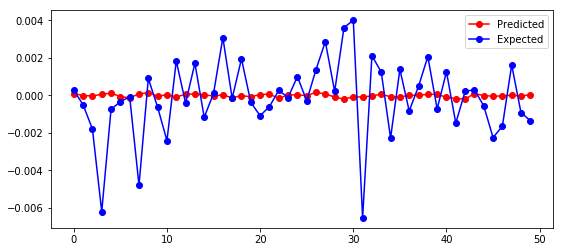

SVR


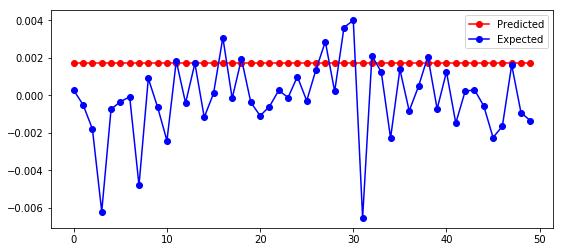

,USD_JPY_volume,USB02Y_USD_volume,USB05Y_USD_volume,USB10Y_USD_volume,USB30Y_USD_volume,UK100_GBP_volume,UK10YB_GBP_volume,JP225_USD_volume,HK33_HKD_volume,EU50_EUR_volume,DE30_EUR_volume,DE10YB_EUR_volume,WTICO_USD_volume,US30_USD_volume,SPX500_USD_volume,Diff USD_JPY_openMid,Diff USD_JPY_volume,Diff USB02Y_USD_closeMid,Diff USB02Y_USD_highMid,Diff USB02Y_USD_lowMid,Diff USB02Y_USD_openMid,Diff USB02Y_USD_volume,Diff USB05Y_USD_closeMid,Diff USB05Y_USD_highMid,Diff USB05Y_USD_lowMid,Diff USB05Y_USD_openMid,Diff USB05Y_USD_volume,Diff USB10Y_USD_closeMid,Diff USB10Y_USD_highMid,Diff USB10Y_USD_lowMid,Diff USB10Y_USD_openMid,Diff USB10Y_USD_volume,Diff USB30Y_USD_closeMid,Diff USB30Y_USD_highMid,Diff USB30Y_USD_lowMid,Diff USB30Y_USD_openMid,Diff USB30Y_USD_volume,Diff UK100_GBP_closeMid,Diff UK100_GBP_highMid,Diff UK100_GBP_lowMid,Diff UK100_GBP_openMid,Diff UK100_GBP_volume,Diff UK10YB_GBP_closeMid,Diff UK10YB_GBP_highMid,Diff UK10YB_GBP_lowMid,Diff UK10YB_GBP_openMid,Diff UK10YB_GBP_volume,Diff JP225_USD_closeMid,Diff JP225_USD_highMid,Diff JP225_USD_lowMid,Diff JP225_USD_openMid,Diff JP225_USD_volume,Diff HK33_HKD_closeMid,Diff HK33_HKD_highMid,Diff HK33_HKD_lowMid,Diff HK33_HKD_openMid,Diff HK33_HKD_volume,Diff EU50_EUR_closeMid,Diff EU50_EUR_highMid,Diff EU50_EUR_lowMid,Diff EU50_EUR_openMid,Diff EU50_EUR_volume,Diff DE30_EUR_closeMid,Diff DE30_EUR_highMid,Diff DE30_EUR_lowMid,Diff DE30_EUR_openMid,Diff DE30_EUR_volume,Diff DE10YB_EUR_closeMid,Diff DE10YB_EUR_highMid,Diff DE10YB_EUR_lowMid,Diff DE10YB_EUR_openMid,Diff DE10YB_EUR_volume,Diff WTICO_USD_closeMid,Diff WTICO_USD_highMid,Diff WTICO_USD_lowMid,Diff WTICO_USD_openMid,Diff WTICO_USD_volume,Diff US30_USD_closeMid,Diff US30_USD_highMid,Diff US30_USD_lowMid,Diff US30_USD_openMid,Diff US30_USD_volume,Diff SPX500_USD_closeMid,Diff SPX500_USD_highMid,Diff SPX500_USD_lowMid,Diff SPX500_USD_openMid,Diff SPX500_USD_volume,intercept,Diff USD_JPY_closeMid,Diff USD_JPY_highMid,Diff USD_JPY_lowMid,future diff high
0,1054,6.0,13.0,11.0,9.0,696.0,152.0,20.0,713.0,1.0,311.0,319.0,154.0,21.0,98.0,0.002407,-0.702590,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001037,0.000999,-0.000806,0.000024,1.426035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000438,0.000000,-0.000175,0.000000,1.001449,1,-0.001545,-0.001825,0.001103,0.000726
1,1939,6.0,34.0,40.0,46.0,696.0,152.0,20.0,713.0,1.0,311.0,319.0,126.0,47.0,105.0,-0.001492,0.609580,-0.000294,-0.000074,-0.000294,-0.000147,0.000000,-0.000883,0.000000,-0.000822,0.000130,0.961411,-0.001356,-0.000137,-0.001081,-0.000137,1.290984,-0.002171,0.000000,-0.001635,0.000812,1.631417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001063,-0.002377,-0.000819,-0.000696,-0.200671,0.000470,0.000658,0.000188,-0.000094,0.805625,0.000263,0.000438,0.000438,0.000000,0.068993,1,-0.000546,0.000726,-0.000728,-0.002394
2,1905,12.0,63.0,45.0,45.0,696.0,152.0,20.0,713.0,1.0,311.0,319.0,171.0,32.0,76.0,-0.000535,-0.017690,-0.000147,-0.000294,-0.000147,-0.000294,0.693147,-0.000208,-0.000753,-0.000277,-0.000883,0.616774,-0.000137,-0.000815,-0.000404,-0.001356,0.117783,-0.000546,-0.001902,-0.000814,-0.002171,-0.021979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000342,-0.000110,-0.000575,-0.001063,0.305382,-0.000385,0.000094,-0.000113,0.000555,-0.384412,-0.000438,0.000263,-0.000263,0.000613,-0.323227,1,-0.000857,-0.002394,-0.001372,-0.000835
3,1438,7.0,22.0,39.0,48.0,696.0,152.0,20.0,2666.0,1.0,311.0,319.0,236.0,21.0,85.0,-0.000

,future diff high
Diff USB05Y_USD_closeMid,-0.251929
Diff USB10Y_USD_closeMid,-0.248853
Diff USB02Y_USD_closeMid,-0.231849
Diff USB30Y_USD_closeMid,-0.218382
Diff USB10Y_USD_highMid,-0.169669
Diff USB05Y_USD_highMid,-0.161379
Diff USB02Y_USD_highMid,-0.160007
Diff USB30Y_USD_highMid,-0.148454
USD_JPY_volume,-0.145878
Diff DE10YB_EUR_closeMid,-0.138966


MSE
6.873128075995374e-07
Diff USD_JPY_highMid
LINREG


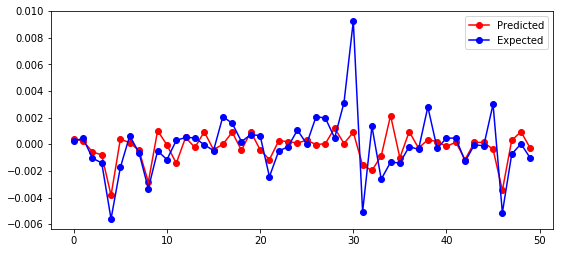

SVR


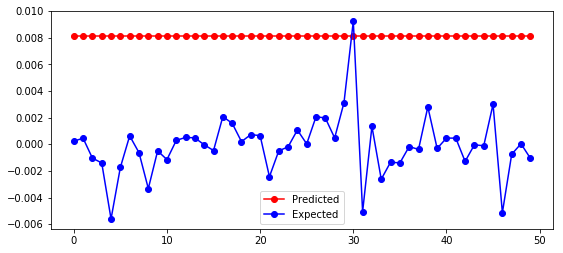

,USD_JPY_volume,USB02Y_USD_volume,USB05Y_USD_volume,USB10Y_USD_volume,USB30Y_USD_volume,UK100_GBP_volume,UK10YB_GBP_volume,JP225_USD_volume,HK33_HKD_volume,EU50_EUR_volume,DE30_EUR_volume,DE10YB_EUR_volume,WTICO_USD_volume,US30_USD_volume,SPX500_USD_volume,Diff USD_JPY_openMid,Diff USD_JPY_volume,Diff USB02Y_USD_closeMid,Diff USB02Y_USD_highMid,Diff USB02Y_USD_lowMid,Diff USB02Y_USD_openMid,Diff USB02Y_USD_volume,Diff USB05Y_USD_closeMid,Diff USB05Y_USD_highMid,Diff USB05Y_USD_lowMid,Diff USB05Y_USD_openMid,Diff USB05Y_USD_volume,Diff USB10Y_USD_closeMid,Diff USB10Y_USD_highMid,Diff USB10Y_USD_lowMid,Diff USB10Y_USD_openMid,Diff USB10Y_USD_volume,Diff USB30Y_USD_closeMid,Diff USB30Y_USD_highMid,Diff USB30Y_USD_lowMid,Diff USB30Y_USD_openMid,Diff USB30Y_USD_volume,Diff UK100_GBP_closeMid,Diff UK100_GBP_highMid,Diff UK100_GBP_lowMid,Diff UK100_GBP_openMid,Diff UK100_GBP_volume,Diff UK10YB_GBP_closeMid,Diff UK10YB_GBP_highMid,Diff UK10YB_GBP_lowMid,Diff UK10YB_GBP_openMid,Diff UK10YB_GBP_volume,Diff JP225_USD_closeMid,Diff JP225_USD_highMid,Diff JP225_USD_lowMid,Diff JP225_USD_openMid,Diff JP225_USD_volume,Diff HK33_HKD_closeMid,Diff HK33_HKD_highMid,Diff HK33_HKD_lowMid,Diff HK33_HKD_openMid,Diff HK33_HKD_volume,Diff EU50_EUR_closeMid,Diff EU50_EUR_highMid,Diff EU50_EUR_lowMid,Diff EU50_EUR_openMid,Diff EU50_EUR_volume,Diff DE30_EUR_closeMid,Diff DE30_EUR_highMid,Diff DE30_EUR_lowMid,Diff DE30_EUR_openMid,Diff DE30_EUR_volume,Diff DE10YB_EUR_closeMid,Diff DE10YB_EUR_highMid,Diff DE10YB_EUR_lowMid,Diff DE10YB_EUR_openMid,Diff DE10YB_EUR_volume,Diff WTICO_USD_closeMid,Diff WTICO_USD_highMid,Diff WTICO_USD_lowMid,Diff WTICO_USD_openMid,Diff WTICO_USD_volume,Diff US30_USD_closeMid,Diff US30_USD_highMid,Diff US30_USD_lowMid,Diff US30_USD_openMid,Diff US30_USD_volume,Diff SPX500_USD_closeMid,Diff SPX500_USD_highMid,Diff SPX500_USD_lowMid,Diff SPX500_USD_openMid,Diff SPX500_USD_volume,intercept,Diff USD_JPY_closeMid,Diff USD_JPY_highMid,Diff USD_JPY_lowMid,future diff low
0,1054,6.0,13.0,11.0,9.0,696.0,152.0,20.0,713.0,1.0,311.0,319.0,154.0,21.0,98.0,0.002407,-0.702590,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001037,0.000999,-0.000806,0.000024,1.426035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000438,0.000000,-0.000175,0.000000,1.001449,1,-0.001545,-0.001825,0.001103,-0.000728
1,1939,6.0,34.0,40.0,46.0,696.0,152.0,20.0,713.0,1.0,311.0,319.0,126.0,47.0,105.0,-0.001492,0.609580,-0.000294,-0.000074,-0.000294,-0.000147,0.000000,-0.000883,0.000000,-0.000822,0.000130,0.961411,-0.001356,-0.000137,-0.001081,-0.000137,1.290984,-0.002171,0.000000,-0.001635,0.000812,1.631417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001063,-0.002377,-0.000819,-0.000696,-0.200671,0.000470,0.000658,0.000188,-0.000094,0.805625,0.000263,0.000438,0.000438,0.000000,0.068993,1,-0.000546,0.000726,-0.000728,-0.001372
2,1905,12.0,63.0,45.0,45.0,696.0,152.0,20.0,713.0,1.0,311.0,319.0,171.0,32.0,76.0,-0.000535,-0.017690,-0.000147,-0.000294,-0.000147,-0.000294,0.693147,-0.000208,-0.000753,-0.000277,-0.000883,0.616774,-0.000137,-0.000815,-0.000404,-0.001356,0.117783,-0.000546,-0.001902,-0.000814,-0.002171,-0.021979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000342,-0.000110,-0.000575,-0.001063,0.305382,-0.000385,0.000094,-0.000113,0.000555,-0.384412,-0.000438,0.000263,-0.000263,0.000613,-0.323227,1,-0.000857,-0.002394,-0.001372,-0.000730
3,1438,7.0,22.0,39.0,48.0,696.0,152.0,20.0,2666.0,1.0,311.0,319.0,236.0,21.0,85.0,-0.000

,future diff low
Diff USB10Y_USD_closeMid,-0.205540
Diff USB05Y_USD_closeMid,-0.204375
Diff USB30Y_USD_closeMid,-0.183736
Diff USB02Y_USD_closeMid,-0.177521
Diff USB10Y_USD_lowMid,-0.125332
Diff USB05Y_USD_lowMid,-0.122303
Diff DE10YB_EUR_closeMid,-0.119438
Diff USB30Y_USD_lowMid,-0.115154
Diff USB02Y_USD_lowMid,-0.109334
Diff UK10YB_GBP_closeMid,-0.101694


MSE
8.6649547570286e-07
Diff USD_JPY_lowMid
LINREG


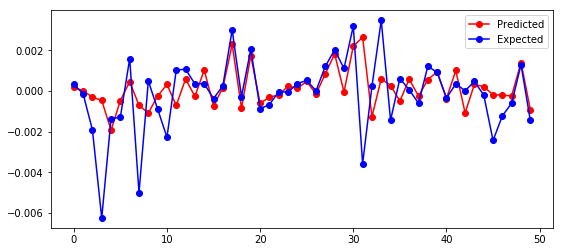

SVR


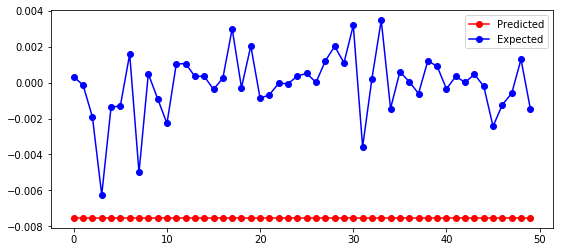

In [54]:
prints = 50
instrument = 'USD_JPY'
scaling = None
models, variables = model_creation(df, instrument, pricediff, prints, scaling)

# Backtesting

In [35]:
def backtest_alignment(DF, pr, instrument, model, pricediff, log):
    """
    Alinea datos para backtest
    
    Args:
        DF (DataFrame): Datos para modelo sin shift
        pr (DataFrame): Precios con fecha (antes de transformaciones)
        instrument (str): Divisa
        model (str): Linreg
        pricediff (bool): Si queremos diferencias
        log (bool): Si hubo transformación logaritmica
    
    Returns:
        bt (DataFrame): Datos para backtest
    """
    if pricediff:
        Actuals = ['Diff {}_closeMid'.format(instrument),
                   'Diff {}_highMid'.format(instrument),
                   'Diff {}_lowMid'.format(instrument)]

        Responses = ['future diff close', 
                     'future diff high',
                     'future diff low']
    else:
        Actuals = ['{}_closeMid'.format(instrument), 
                   '{}_highMid'.format(instrument),
                   '{}_lowMid'.format(instrument)]
        
        Responses = ['future close',
                     'future high',
                     'future low']

    date = '{}_date'.format(instrument)
    backtest = Actuals.copy()
    backtest.insert(0, date)

    bt = pr[backtest]

    for actual, response in zip(Actuals, Responses):
        df = DF.copy()
        df[response] = df[actual].shift(-1)
        x = df.drop(response, axis=1).values
        y = df[response].values
        x = sm.add_constant(x, prepend=True, has_constant='skip')
        mod = models['{}_{}'.format(model, actual)]
        bt['Expected ' + actual] = y
        bt['Predicted ' + actual] = mod.predict(x)
        plt.figure(figsize=(9,4))
        print(actual)
        plt.plot(range(len(bt[:prints])),bt['Predicted {}'.format(actual)][:prints], color='r', marker='o', label='Predicted')
        plt.plot(range(len(bt[:prints])),bt['Expected {}'.format(actual)][:prints], color='b', marker='o', label='Expected')
        plt.legend()
        plt.show()

    drop = [i for i in bt.columns if 'Expected' in i]
    shifts = [i for i in bt.columns if 'Predicted' in i]
    
    
    # Regresa transformación logaritmica
    for i in shifts:
        bt[i] = bt[i].shift(1)
        if log:
            bt[i] = np.exp(bt[i])

    bt = bt.drop(drop, axis=1)
    bt = bt.dropna()

    return bt

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Diff USD_JPY_closeMid


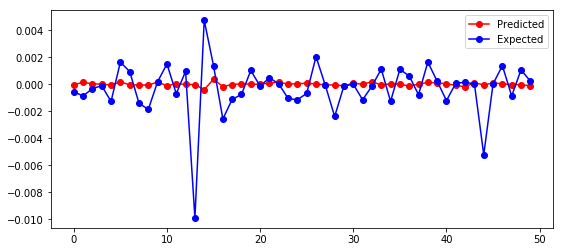

Diff USD_JPY_highMid


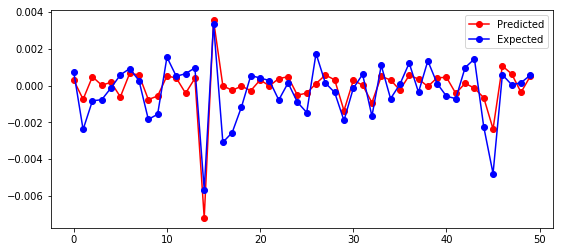

Diff USD_JPY_lowMid


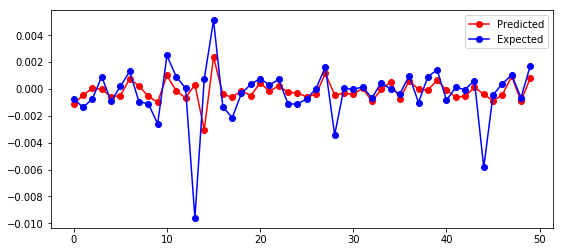

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
bt = backtest_alignment(df, pr, instrument, 'Linreg', pricediff, log)

In [37]:
instrument = 'USD_JPY'
instruments = ['USD_JPY']

In [38]:
btprices = get_forex(instrument, instruments, granularity, start, end, candleformat, freq)

USD_JPY
Descargando:


HBox(children=(IntProgress(value=0, max=215), HTML(value='')))

In [39]:
def prices_alignment(btp, instrument):
    """
    Alineación de precios reales
    
    Args:
        btp (DataFrame): Precios
        instrument (str): Divisa
    
    Returns:
        btp (DataFrame): Alineado
    """
    btprices = btp.copy() 
    cols = [date,
            '{}_closeMid'.format(instrument), 
            '{}_highMid'.format(instrument),
            '{}_lowMid'.format(instrument)]

    btprices = btprices[cols]
    btprices[date] = btprices[date].astype(str)
    btprices[date] = btprices[date].str[:13]
    
    return btprices

In [40]:
btprices = prices_alignment(btprices, instrument)

In [41]:
BT = pd.merge(bt, btprices, on=date, how='inner')

In [50]:
def backtesting(BT, limit, trainsize, pricediff):
    """
    BT
    limit
    trainsize
    pricediff
    """

    if pricediff:

        BT['Prediction close'] = BT['{}_closeMid'.format(instrument)].shift(1)*BT['Predicted Diff {}_closeMid'.format(instrument)]
        BT['Prediction high'] = BT['{}_highMid'.format(instrument)].shift(1)*BT['Predicted Diff {}_highMid'.format(instrument)]
        BT['Prediction low'] = BT['{}_lowMid'.format(instrument)].shift(1)*BT['Predicted Diff {}_lowMid'.format(instrument)]
        BT = BT.dropna()

        test = BT[['{}_closeMid'.format(instrument), 'Prediction close',
                    '{}_highMid'.format(instrument), 'Prediction high',
                    '{}_lowMid'.format(instrument), 'Prediction low']]
    else:
        BT['Prediction close'] = BT['Predicted {}_closeMid'.format(instrument)]
        BT['Prediction high'] = BT['Predicted {}_highMid'.format(instrument)]
        BT['Prediction low'] = BT['Predicted {}_lowMid'.format(instrument)]

        BT = BT.dropna()

        test = BT[['{}_closeMid_y'.format(instrument), 'Prediction close',
                    '{}_highMid_y'.format(instrument), 'Prediction high',
                    '{}_lowMid_y'.format(instrument), 'Prediction low']]

    test = test.round(3)

    profit = test[test.columns[:2]]
    profit.columns = ['Touch High', 'Touch Low']
    profit[:] = 0

    if pricediff:

        profit['Touch High'] = test['Prediction high'] - limit <= test['{}_highMid'.format(instrument)]
        profit['Touch Low'] = test['Prediction low'] + limit >= test['{}_lowMid'.format(instrument)]
    else:
        profit['Touch High'] = test['Prediction high'] - limit <= test['{}_highMid_y'.format(instrument)]
        profit['Touch Low'] = test['Prediction low'] + limit >= test['{}_lowMid_y'.format(instrument)]

    if pricediff:
        profit['Buy'] = 0
        profit.loc[(profit['Touch High']) & \
                   (test['Prediction high'] - limit - test['{}_closeMid'.format(instrument)] >= 0), 'Buy'] = \
                    test['Prediction high'] - limit - test['{}_closeMid'.format(instrument)]

        profit.loc[(~profit['Touch High']) & \
                   (test['Prediction high'] - test['{}_closeMid'.format(instrument)] >= 0) & \
                   (test['{}_lowMid'.format(instrument)] < test['Prediction low']), 'Buy'] = \
                   (test['Prediction low'] - test['{}_closeMid'.format(instrument)])

        profit['Sell'] = 0
        profit.loc[(profit['Touch Low']) & \
                   (test['{}_closeMid'.format(instrument)] - (test['Prediction low'] + limit) >= 0), 'Sell'] = \
                    test['{}_closeMid'.format(instrument)] - (test['Prediction low'] + limit)

        profit.loc[(~profit['Touch Low']) & \
                   (test['{}_closeMid'.format(instrument)] - (test['Prediction low'] + limit) >= 0) & \
                   (test['{}_highMid'.format(instrument)] > test['Prediction high']), 'Sell'] = \
                   (test['{}_closeMid'.format(instrument)] - test['Prediction high'])

    else:
        profit['Buy'] = 0
        profit.loc[(profit['Touch High']) & \
                   (test['Prediction high'] - limit - test['{}_closeMid_y'.format(instrument)] >= 0), 'Buy'] = \
                    test['Prediction high'] - limit - test['{}_closeMid_y'.format(instrument)]

        profit.loc[(~profit['Touch High']) & \
                   (test['Prediction high'] - test['{}_closeMid_y'.format(instrument)] >= 0) & \
                   (test['{}_lowMid_y'.format(instrument)] < test['Prediction low']), 'Buy'] = \
                   (test['Prediction low'] - test['{}_closeMid_y'.format(instrument)])

        profit['Sell'] = 0
        profit.loc[(profit['Touch Low']) & \
                   (test['{}_closeMid_y'.format(instrument)] - (test['Prediction low'] + limit) >= 0), 'Sell'] = \
                    test['{}_closeMid_y'.format(instrument)] - (test['Prediction low'] + limit)

        profit.loc[(~profit['Touch Low']) & \
                   (test['{}_closeMid_y'.format(instrument)] - (test['Prediction low'] + limit) >= 0) & \
                   (test['{}_highMid_y'.format(instrument)] > test['Prediction high']), 'Sell'] = \
                   (test['{}_closeMid_y'.format(instrument)] - test['Prediction high'])

    profit = profit.round(3)

    profit = profit[int(trainsize*len(profit)):]
    print('Buy Win Ratio')
    print(round(len(profit[profit['Touch High']])/len(profit),3))
    print('\nSell Win Ratio')
    print(round(len(profit[profit['Touch Low']])/len(profit),3))
    return test, profit


In [52]:
limit = 0.02
trainsize = 0.75
test, profit = backtesting(BT, limit, trainsize, pricediff)

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(key, value)
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return

Buy Win Ratio
0.666

Sell Win Ratio
0.61


# Trading

In [56]:
if pricediff:
    Actuals = ['Diff {}_closeMid'.format(instrument),
               'Diff {}_highMid'.format(instrument),
               'Diff {}_lowMid'.format(instrument)]

    Responses = ['future diff close', 
                 'future diff high',
                 'future diff low']
else:
    Actuals = ['{}_closeMid'.format(instrument), 
               '{}_highMid'.format(instrument),
               '{}_lowMid'.format(instrument)]

    Responses = ['future close',
                 'future high',
                 'future low']

In [117]:
candleformat = 'midpoint' # ['midpoint', 'bidask']
instrument = 'USD_JPY'
instruments = ['USD_JPY', 
               'USB02Y_USD',
               'USB05Y_USD',
               'USB10Y_USD', 
               'USB30Y_USD',
               'UK100_GBP',
               'UK10YB_GBP',
               'JP225_USD',
               'HK33_HKD',
               'EU50_EUR',
               'DE30_EUR',
               'DE10YB_EUR',
               'WTICO_USD',
               'US30_USD',
               'SPX500_USD']
               
granularity = 'H1'
start = '2018-11-07'
end = str(dt.now())
freq = 'D'
trading = True
fx = get_forex(instrument, instruments, granularity, start, end, candleformat, freq, trading)

USD_JPY
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


USB02Y_USD
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


USB05Y_USD
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


USB10Y_USD
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


USB30Y_USD
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


UK100_GBP
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


UK10YB_GBP
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


JP225_USD
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


HK33_HKD
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


EU50_EUR
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


DE30_EUR
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


DE10YB_EUR
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


WTICO_USD
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


US30_USD
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


SPX500_USD
Descargando:


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

In [163]:
instrument = 'USD_JPY'
pricediff = True
log = True
min_window = None
candleformat = 'midpoint' # ['midpoint', 'bidask']
trading = True

afx = adjust_lags(fx, 
                  min_window=min_window,
                  instrument=instrument,
                  pricediff=pricediff, 
                  candleformat=candleformat,
                  log=log,
                  trading=trading)

ufunc 'log' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


In [164]:
afx['intercept'] = 1

In [165]:
prices = [i.replace('Diff ', '') for i in Actuals]

In [166]:
prices.append('{}_date'.format(instrument))

In [167]:
fxp = fx[prices]
fxp['{}_date'.format(instrument)] = fxp['{}_date'.format(instrument)].astype(str)
fxp['{}_date'.format(instrument)] = fxp['{}_date'.format(instrument)].str[:13]

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [168]:
fxp = fxp.drop(0)

In [169]:
for i in Actuals:
    df = afx[variables[i]]
    x = df.values
    x = sm.add_constant(x, prepend=True, has_constant='skip')
    imod = 'Linreg_' + i
    mod = models[imod]
    if pricediff:
        act = i.replace('Diff ', '')
    fxp['Future ' + act] = np.exp(mod.predict(x))*fxp[act]

In [172]:
fxp.iloc[-1]

USD_JPY_closeMid                 114.019
USD_JPY_highMid                  114.056
USD_JPY_lowMid                   114.018
USD_JPY_date               2018-11-08 23
Future USD_JPY_closeMid          114.031
Future USD_JPY_highMid           114.042
Future USD_JPY_lowMid            113.998
Name: 499, dtype: object